In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.stem.porter import PorterStemmer
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, BatchNormalization
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import os

def load_dataset(data_dir):
    texts, labels = [], []
    categories = os.listdir(data_dir)
    
    for label, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
                texts.append(f.read())
                labels.append(label)
    
    return texts, labels, categories

data_dir = r"C:\Users\devan\AI-ML\3_NLP_Project_Document_Classification\Data"
texts, labels, categories = load_dataset(data_dir)


In [3]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)  # keep only letters
    words = text.split()
    words = [w for w in words if w not in stop_words]  # remove stopwords
    return " ".join(words)

cleaned_texts = [clean_text(t) for t in texts]

print("Before:", texts[0][:200])
print("After:", cleaned_texts[0][:200])


Before: Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one o
After: ad sales boost time warner profit quarterly profits us media giant timewarner jumped bn three months december yearearlier firm one biggest investors google benefited sales highspeed internet connectio


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\devan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def read_files_and_add_folder_name(folder_path):
    # Create an empty list to store file data and folder names
    data = []
    
    # Loop through each file in the folder
    for root, _, files in os.walk(folder_path):
        for file_name in files:            
            file_path = os.path.join(root, file_name)
            folder_name = os.path.basename(root)
            
            # Try reading with utf-8, fallback to latin1 if needed
            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    file_content = file.read()
            except UnicodeDecodeError:
                with open(file_path, 'r', encoding='latin1', errors='ignore') as file:
                    file_content = file.read()
            
            # Append the file data and folder name to the list
            data.append([file_name, folder_name, file_content])
    
    # Create a DataFrame from the collected data
    df = pd.DataFrame(data, columns=['File_Name', 'Category', 'File_Content'])
    return df
# Replace 'folder_path' with the path to your folder containing the documents
folder_path = "C:\\Users\\devan\\AI-ML\\3_NLP_Project_Document_Classification\\Data"
df = read_files_and_add_folder_name(folder_path)    



In [5]:
df.head(2)

,File_Name,Category,File_Content
0,001.txt,business,Ad sales boost Time Warner profit\n\nQuarterly...
1,002.txt,business,Dollar gains on Greenspan speech\n\nThe dollar...


In [6]:
df['Category'].value_counts()

Category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

In [7]:
df['File_Content'][0]

'Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sig

Category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


C:\Users\devan\AppData\Local\Temp\ipykernel_22196\1685633615.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df, x = "Category", palette = "RdBu")


Text(0.5, 1.0, 'The Distribution of Category')

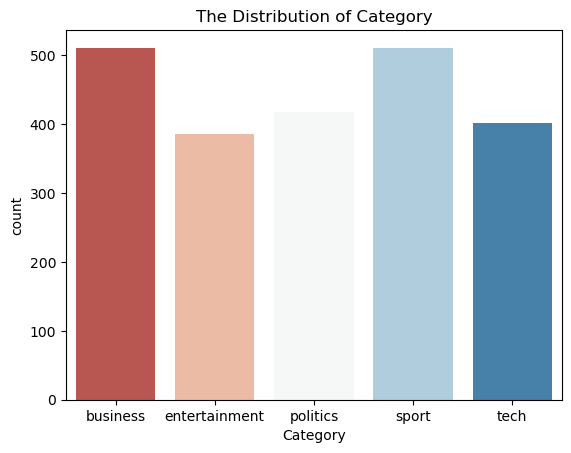

In [8]:
print(df['Category'].value_counts())
sns.countplot(data = df, x = "Category", palette = "RdBu")
plt.title("The Distribution of Category")

In [9]:
# Lets calculate the length of the Documents
df['length'] = df['File_Content'].apply(len)

In [10]:
df.head(2)

,File_Name,Category,File_Content,length
0,001.txt,business,Ad sales boost Time Warner profit\n\nQuarterly...,2559
1,002.txt,business,Dollar gains on Greenspan speech\n\nThe dollar...,2252


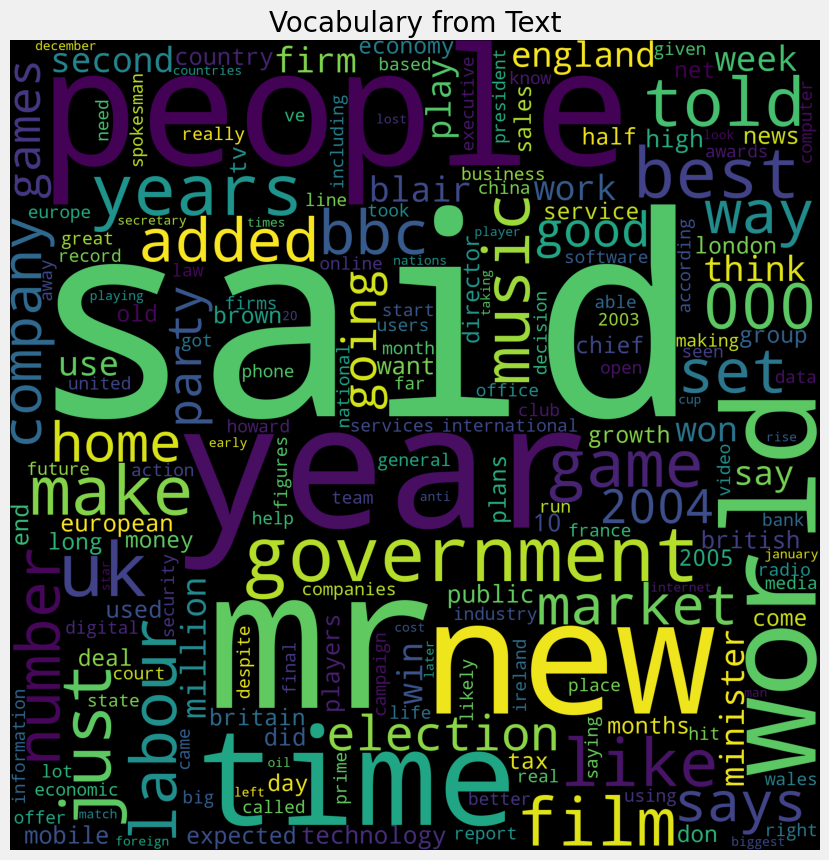

In [11]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df['File_Content'])
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

wordcloud = WordCloud(background_color = 'black', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Vocabulary from Text", fontsize = 20)
plt.show()

In [12]:
def create_labels(class_names):
    # Create an empty dictionary to store the class labels
    class_labels = {}
    
    # Assign a label (integer) to each class name
    for i, class_name in enumerate(class_names):
        class_labels[class_name] = i
        
    return class_labels

class_names = ['sport', 'business', 'politics', 'tech', 'entertainment']

# Create labels for the classes
labels = create_labels(class_names)
print(labels)


# Map the class names to their labels and create a new column for labels
df['Class_Label'] = df['Category'].map(labels)

{'sport': 0, 'business': 1, 'politics': 2, 'tech': 3, 'entertainment': 4}


In [13]:
df.head(2)

,File_Name,Category,File_Content,length,Class_Label
0,001.txt,business,Ad sales boost Time Warner profit\n\nQuarterly...,2559,1
1,002.txt,business,Dollar gains on Greenspan speech\n\nThe dollar...,2252,1


In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [15]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\devan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\devan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\devan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
# Function to clean and preprocess the docs
def clean_reviews(docs):
    lemmatizer = WordNetLemmatizer()
    clean_docs = []
    for doc in data['File_Content'].values:
        doc = doc.lower()  # Convert to lowercase
        doc = re.sub(r'\d+', '', doc)  # Remove digits
        doc = re.sub(r'[^\w\s]', '', doc)  # Remove special characters
        words = nltk.word_tokenize(doc)  # Tokenize the text
        words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]  # Lemmatize and remove stopwords
        clean_docs.append(' '.join(words))        
    #data['File_Content_cleaned'] = clean_docs
    #data['cleaned_length'] = df['File_Content_cleaned'].apply(len)
    return data

In [17]:
# Function to clean and preprocess the docs
def clean_reviews(docs):
    lemmatizer = WordNetLemmatizer()
    clean_docs = []
    for doc in docs:
        doc = doc.lower()  # Convert to lowercase
        doc = re.sub(r'\d+', '', doc)  # Remove digits
        doc = re.sub(r'[^\w\s]', '', doc)  # Remove special characters
        words = nltk.word_tokenize(doc)  # Tokenize the text
        words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]  # Lemmatize and remove stopwords
        clean_docs.append(' '.join(words))        
    #data['File_Content_cleaned'] = clean_docs
    #data['cleaned_length'] = df['File_Content_cleaned'].apply(len)
    return clean_docs

In [ ]:
df['new_cleaned'] = df['File_Content'].apply(clean_reviews)

In [ ]:
# Preprocess the docs
df_cleaned = clean_reviews(df)

In [ ]:
df_cleaned.head(2)

,File_Name,Category,File_Content,length,Class_Label,File_Content_cleaned,cleaned_length
0,001.txt,business,Ad sales boost Time Warner profit\n\nQuarterly...,2560,1,ad sale boost time warner profit quarterly pro...,1734
1,002.txt,business,Dollar gains on Greenspan speech\n\nThe dollar...,2252,1,dollar gain greenspan speech dollar hit highes...,1561


#### convert the text data into numerical data by using word2vec

Word2Vec is a popular word embedding technique that represents words as dense vectors in a high-dimensional space. It captures semantic relationships between words and is widely used in natural language processing tasks. There are two main architectures for Word2Vec: Continuous Bag of Words (CBOW) and Skip-gram.

Continuous Bag of Words (CBOW):
    In CBOW, the model tries to predict the target word based on its context words. The context words are the words surrounding the target word within a fixed window size. The idea is to use the context information to learn word embeddings.

For example, given the sentence "I love machine learning," and considering a window size of 2, the context words for the target word "love" would be ["I", "machine"]. The CBOW model then tries to predict "love" based on these context words.

Skip-gram:
    In Skip-gram, the model does the opposite; it predicts the context words given the target word. It tries to learn word embeddings that are good at predicting the context words.

For example, given the sentence "I love machine learning," and considering a window size of 2, the Skip-gram model takes the target word "love" and tries to predict ["I", "machine"] as its context words.

Training Process:
Both CBOW and Skip-gram use a neural network to learn word embeddings. The network typically consists of an input layer, a hidden layer (or multiple layers), and an output layer.

The input layer represents the target or context word as a one-hot encoded vector, and the output layer represents the predicted word (in the case of CBOW) or context words (in the case of Skip-gram). The hidden layer(s) learn the word embeddings.

During training, the model optimizes the embeddings to minimize the difference between predicted and actual words. Once the training is complete, the model has learned word embeddings that capture semantic relationships between words.

Applying Word2Vec to Sentences:
To apply Word2Vec to sentences, you typically tokenize the sentences into individual words and then train the Word2Vec model on the corpus of these words. Once trained, you can use the word embeddings to represent sentences. There are different strategies to obtain a sentence-level embedding from individual word embeddings, such as averaging or concatenating the word vectors.

Overall, Word2Vec allows you to capture the meaning of words and sentences in a dense vector space, enabling various natural language processing tasks like sentiment analysis, machine translation, and document similarity.

word2vec -- word to vector

Male --- [[10,10.5,11,13,0.6.0.8,15 ------100]]    ---  in to vector of multiple   ---0 to 1 0.8 -- relation ship is there 
Female --[[10,10.5,11,12.6,0.8,0.7,12,-----100]]

King and queen   --  semantic relationship -- -- 0.9 -- the words are near by

bread and better -- 

male, egg -- 0.3 -- no relatioship betwen these words

Thanks&Regards:
    
Milk and butter

cold and medicine



Thanks  -- u will be getting suggestion as Regards --


Word2vec for sentences 

sentence --The king is travelling by horse
after sentence clean up

king travel horse   -- into one vector   -- either u can average the vectors or sum the vectors

king   -- vector1 with size of 100-- [[10,10.5,11,13,0.6.0.8,15 ------100]]
travel -- vector2 with size of 100 - [[10,10.5,11,12.6,0.8,0.7,12,-----100]]
horse -- vector3 with size of 100 -- [[10,10.5,11,12.6,0.8,0.7,12,-----100]]

[10+10+10/3, 10.5+10.5+10.5/3,13+12.6+12/3,---------100]


In [ ]:
# Train the Word2Vec model
word2vec_model = Word2Vec(sentences=df_cleaned['File_Content_cleaned'], vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# Save Word2Vec model
word2vec_model.save("word2vec_model.bin")

In [ ]:
# Function to get the sentence-level embedding by averaging word embeddings
def get_sentence_embedding(tokens):
    embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    #print(embeddings)
    if embeddings:
        return np.mean(embeddings, axis=0)  # this linr to avearge the word vectors of a sentance
    return None

In [ ]:
# Apply the function to get the sentence embeddings
df_cleaned['sentence_embedding'] = df_cleaned['File_Content_cleaned'].apply(get_sentence_embedding)

In [ ]:
df_cleaned.head(2)

,File_Name,Category,File_Content,length,Class_Label,File_Content_cleaned,cleaned_length,sentence_embedding
0,001.txt,business,Ad sales boost Time Warner profit\n\nQuarterly...,2560,1,ad sale boost time warner profit quarterly pro...,1734,"[-0.009415408, 0.10044906, 0.02437886, -0.0356..."
1,002.txt,business,Dollar gains on Greenspan speech\n\nThe dollar...,2252,1,dollar gain greenspan speech dollar hit highes...,1561,"[-0.008759484, 0.11562879, 0.033075213, -0.014..."


In [ ]:
df_cleaned['sentence_embedding'][0]

array([-0.00941541,  0.10044906,  0.02437886, -0.03568116,  0.04692131,
        0.02681155,  0.04412121,  0.119882  , -0.06253979, -0.04760404,
       -0.00870944, -0.07746842,  0.04231077, -0.03967683, -0.01168702,
       -0.04002358,  0.03872373, -0.07080904,  0.03277781, -0.07930022,
       -0.03198984, -0.0326666 ,  0.03951186, -0.0473818 , -0.16965331,
        0.05378747,  0.00171796, -0.0128455 , -0.03681337,  0.086192  ,
        0.11369918, -0.07542384, -0.04115093, -0.05574084, -0.02887836,
        0.05410201, -0.0443188 ,  0.02068722, -0.06934914,  0.0367716 ,
        0.16545284, -0.02946435,  0.0007093 ,  0.03894565,  0.06018454,
       -0.0660078 ,  0.0009232 , -0.10705002, -0.02049143, -0.00572364,
        0.07423571, -0.02012079,  0.08304344, -0.01949525, -0.07720615,
       -0.06081194,  0.00394238, -0.00927278,  0.02109537, -0.08342674,
       -0.03623226, -0.08661192,  0.06946923,  0.02822352, -0.03976869,
        0.12262892,  0.03637401,  0.07732549, -0.07163745,  0.01

In [ ]:
len(df_cleaned['sentence_embedding'][0])

100

In [ ]:
df_cleaned.isna().sum()

File_Name               0
Category                0
File_Content            0
length                  0
Class_Label             0
File_Content_cleaned    0
cleaned_length          0
sentence_embedding      0
dtype: int64

In [ ]:
X = df_cleaned['sentence_embedding']
y = df_cleaned['Class_Label']

In [ ]:
X.shape

(2225,)

In [ ]:
X = np.vstack(df_cleaned['sentence_embedding'].values)

In [ ]:
y = df_cleaned['Class_Label'].values

In [ ]:
X

array([[-0.00941541,  0.10044906,  0.02437886, ...,  0.02071057,
         0.06626727,  0.02410253],
       [-0.00875948,  0.11562879,  0.03307521, ...,  0.01486312,
         0.05373345,  0.02316601],
       [-0.00444654,  0.09338518,  0.01067359, ...,  0.01348669,
         0.05713343,  0.00845625],
       ...,
       [-0.01265233,  0.10471249,  0.02589145, ...,  0.02279736,
         0.05918849,  0.02936962],
       [-0.02269512,  0.09746451,  0.02661631, ...,  0.01841027,
         0.06340384,  0.02285457],
       [-0.02181829,  0.10810588,  0.0263568 , ...,  0.01648076,
         0.05939145,  0.02043914]], dtype=float32)

In [ ]:
X.shape

(2225, 100)

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
X_train.shape

(2002, 100)

In [ ]:
# Build the Random Forest Classifier model
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Evaluate the model on the test set
y_pred = rf_model.predict(X_test)

# Calculate and print the confusion matrix and classification report
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

Confusion Matrix:
[[33  7  5  2  2]
 [ 3 36  9  4  6]
 [ 5  7 19  5  0]
 [ 1 11  2 23  0]
 [ 7 12  3  1 20]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        49
           1       0.49      0.62      0.55        58
           2       0.50      0.53      0.51        36
           3       0.66      0.62      0.64        37
           4       0.71      0.47      0.56        43

    accuracy                           0.59       223
   macro avg       0.61      0.58      0.59       223
weighted avg       0.60      0.59      0.59       223



    Precision:
    Precision is the ratio of true positive predictions to the total number of positive predictions made by the classifier. It measures how many of the instances predicted as positive were actually correct. High precision indicates that the classifier is making fewer false positive predictions.

Formula: Precision = True Positives / (True Positives + False Positives)

    Recall (also known as Sensitivity or True Positive Rate):
    Recall is the ratio of true positive predictions to the total number of actual positive instances in the dataset. It measures how many of the actual positive instances were correctly identified by the classifier. High recall indicates that the classifier is capturing a higher proportion of positive instances.

Formula: Recall = True Positives / (True Positives + False Negatives)

    F1-Score:
    The F1-score is the harmonic mean of precision and recall. It is used to balance the trade-off between precision and recall. The F1-score provides a single value that represents the overall performance of the classifier. It is particularly useful when the dataset is imbalanced, meaning there is a significant difference in the number of instances between different classes.

Formula: F1-Score = 2 * (Precision * Recall) / (Precision + Recall)

    Support:
    Support is the number of occurrences of each class in the test dataset. It represents the actual number of instances belonging to each class.

The classification report presents these metrics for each class in the dataset, providing a comprehensive evaluation of the classifier's performance across different classes. It helps in understanding how well the model performs for each class and identifies potential issues, such as imbalanced classes or specific classes with low precision or recall.

In [ ]:
def model_validation(X_train,y_train,X_test,y_test):
    try:
        validation_table_train=[]
        validation_table_test=[]
        #models=[LogisticRegression,KNeighborsClassifier,GaussianNB,DecisionTreeClassifier,RandomForestClassifier,BaggingClassifier]
        models=[DecisionTreeClassifier,RandomForestClassifier]
        for i in models:
            rd=i()
            rd.fit(X_train,y_train)
            #rd.predict(X_train)
            Train_Accuracy= accuracy_score(y_train, rd.predict(X_train))
            Confusion_Matrix= confusion_matrix(y_train, rd.predict(X_train))
            validation_table_train.append([i,Train_Accuracy,Confusion_Matrix])

            print("training completed for model: ", i)

            Test_Accuracy= accuracy_score(y_test, rd.predict(X_test))
            Confusion_Matrix_test= confusion_matrix(y_test, rd.predict(X_test))
            validation_table_test.append([i,Test_Accuracy,Confusion_Matrix_test])

        validation_table_train=pd.DataFrame(validation_table_train)
        validation_table_train.columns=["model name","Accuracy","confusion matrix"]

        validation_table_test=pd.DataFrame(validation_table_test)
        validation_table_test.columns=["model name","Accuracy","confusion matrix"]


        return validation_table_train,validation_table_test
    
    except Exception as e:
        print("model_validation function failed to run")
        print(e)

In [ ]:
validation_table_train,validation_table_test = model_validation(X_train,y_train,X_test,y_test)

training completed for model:  <class 'sklearn.tree._classes.DecisionTreeClassifier'>
training completed for model:  <class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [ ]:
validation_table_train

,model name,Accuracy,confusion matrix
0,<class 'sklearn.tree._classes.DecisionTreeClas...,1.0,"[[462, 0, 0, 0, 0], [0, 452, 0, 0, 0], [0, 0, ..."
1,<class 'sklearn.ensemble._forest.RandomForestC...,1.0,"[[462, 0, 0, 0, 0], [0, 452, 0, 0, 0], [0, 0, ..."


In [ ]:
validation_table_test

,model name,Accuracy,confusion matrix
0,<class 'sklearn.tree._classes.DecisionTreeClas...,0.439462,"[[27, 3, 6, 4, 9], [5, 25, 11, 6, 11], [6, 6, ..."
1,<class 'sklearn.ensemble._forest.RandomForestC...,0.569507,"[[33, 9, 4, 2, 1], [2, 37, 11, 2, 6], [7, 7, 1..."


### Let's build Deep Learning Model on the data

In [ ]:
# Convert labels to one-hot encoded format to feed into the DL Model
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

In [ ]:
y_train_onehot

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
X_train.shape

(2002, 100)

In [ ]:
# Build the deep neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='softmax'))  # 5 classes in the dataset

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
epochs = 50
batch_size = 32


ePOCH1:
    bATCH-SIze- 8 means -- 8 rows of data --- weights -- w0,w1,w2 ------- w100   --- it will test on 10% of daat - val accuracy
    batch size -- 8 ---- weights will get update
    -
    -
    -
    -
    -
    final weights will update in epoch 1
    
EPOCH2:
    
    

model.fit(X_train, y_train_onehot, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test_onehot)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

Epoch 1/50
226/226 [==============================] - 2s 5ms/step - loss: 1.6067 - accuracy: 0.2293 - val_loss: 1.6002 - val_accuracy: 0.2935
Epoch 2/50
226/226 [==============================] - 1s 4ms/step - loss: 1.5945 - accuracy: 0.2926 - val_loss: 1.5683 - val_accuracy: 0.3234
Epoch 3/50
226/226 [==============================] - 1s 4ms/step - loss: 1.5467 - accuracy: 0.3259 - val_loss: 1.4979 - val_accuracy: 0.3383
Epoch 4/50
226/226 [==============================] - 1s 5ms/step - loss: 1.4881 - accuracy: 0.3309 - val_loss: 1.5034 - val_accuracy: 0.3184
Epoch 5/50
226/226 [==============================] - 1s 4ms/step - loss: 1.4354 - accuracy: 0.3531 - val_loss: 1.4688 - val_accuracy: 0.3284
Epoch 6/50
226/226 [==============================] - 1s 4ms/step - loss: 1.4139 - accuracy: 0.3692 - val_loss: 1.4176 - val_accuracy: 0.3881
Epoch 7/50
226/226 [==============================] - 1s 4ms/step - loss: 1.4089 - accuracy: 0.3720 - val_loss: 1.3981 - val_accuracy: 0.3980
Epoch 

7/7 [==============================] - 0s 3ms/step
Confusion Matrix:


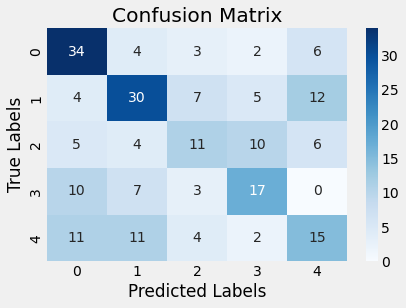

In [ ]:
# Evaluate the best model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
#print(conf_matrix)

# Visualize the confusion matrix as a heatmap
class_names = list(set(y_test))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

63/63 [==============================] - 0s 2ms/step
Confusion Matrix:


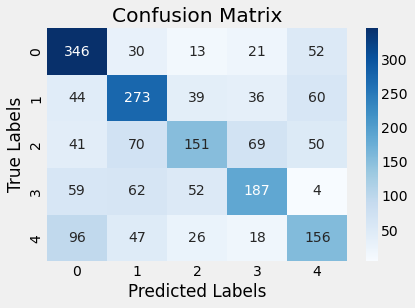

In [ ]:
# Evaluate the model on the train set
y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_train_onehot, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
#print(conf_matrix)

# Visualize the confusion matrix as a heatmap
class_names = list(set(y_train))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Deep Neural network with drop out layer and batch Normalisation

In [ ]:
%%time
# Build the deep neural network model
model = Sequential()

# Input layer
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))

# Additional hidden layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(BatchNormalization())  # Batch Normalization to improve convergence

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Output layer
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
epochs = 50
batch_size = 8

model.fit(X_train, y_train_onehot, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test_onehot)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

Epoch 1/50
226/226 [==============================] - 3s 6ms/step - loss: 1.9300 - accuracy: 0.2449 - val_loss: 1.6131 - val_accuracy: 0.1841
Epoch 2/50
226/226 [==============================] - 1s 7ms/step - loss: 1.6929 - accuracy: 0.2765 - val_loss: 1.5405 - val_accuracy: 0.3433
Epoch 3/50
226/226 [==============================] - 1s 5ms/step - loss: 1.5646 - accuracy: 0.3259 - val_loss: 1.5524 - val_accuracy: 0.2786
Epoch 4/50
226/226 [==============================] - 1s 6ms/step - loss: 1.4817 - accuracy: 0.3620 - val_loss: 1.4905 - val_accuracy: 0.3085
Epoch 5/50
226/226 [==============================] - 2s 8ms/step - loss: 1.4499 - accuracy: 0.3703 - val_loss: 1.7010 - val_accuracy: 0.4179
Epoch 6/50
226/226 [==============================] - 2s 7ms/step - loss: 1.4009 - accuracy: 0.3976 - val_loss: 1.4442 - val_accuracy: 0.4030
Epoch 7/50
226/226 [==============================] - 1s 6ms/step - loss: 1.3535 - accuracy: 0.4209 - val_loss: 1.4404 - val_accuracy: 0.3980
Epoch 

7/7 [==============================] - 0s 3ms/step
Confusion Matrix:


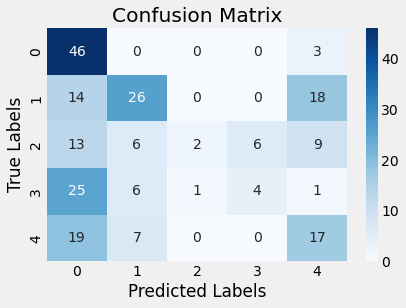

In [ ]:
# Evaluate the best model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
#print(conf_matrix)

# Visualize the confusion matrix as a heatmap
class_names = list(set(y_test))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

63/63 [==============================] - 0s 2ms/step
Confusion Matrix:


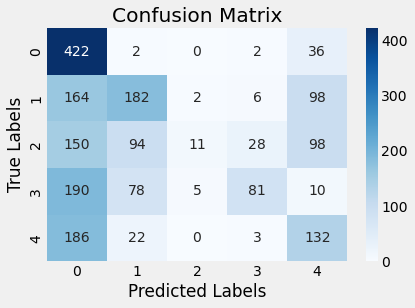

In [ ]:
# Evaluate the model on the train set
y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_train_onehot, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
#print(conf_matrix)

# Visualize the confusion matrix as a heatmap
class_names = list(set(y_train))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Deep Neural network with Hyper parameter tuning using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Create a function to build the deep neural network model
def build_model(hidden_layers=1, neurons=64, dropout_layers=0, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)))
    for _ in range(hidden_layers):
        model.add(Dense(neurons, activation='relu'))
        if dropout_layers > 0:
            model.add(Dropout(dropout_rate))
            dropout_layers -= 1
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create a KerasClassifier with the build_model function
model = KerasClassifier(build_fn=build_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'hidden_layers': [1, 2, 3],
    'neurons': [32, 64, 128],
    'dropout_layers': [0, 1, 2],
    'dropout_rate': [0.2, 0.3, 0.4],
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train_onehot)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Build the best model based on the best parameters
best_model = build_model(hidden_layers=best_params['hidden_layers'],
                         neurons=best_params['neurons'],
                         dropout_layers=best_params['dropout_layers'],
                         dropout_rate=best_params['dropout_rate'])

# Train the best model
best_model.fit(X_train, y_train_onehot, epochs=50, batch_size=32, validation_split=0.1)

# Evaluate the best model on the test set
loss, accuracy = best_model.evaluate(X_test, y_test_onehot)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

C:\Users\gn221m\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Best parameters: {'dropout_layers': 1, 'dropout_rate': 0.2, 'hidden_layers': 1, 'neurons': 32}
Epoch 1/50
57/57 [==============================] - 1s 9ms/step - loss: 1.6085 - accuracy: 0.2232 - val_loss: 1.6040 - val_accuracy: 0.1891
Epoch 2/50
57/57 [==============================] - 0s 4ms/step - loss: 1.6034 - accuracy: 0.2432 - val_loss: 1.5995 - val_accuracy: 0.3483
Epoch 3/50
57/57 [==============================] - 0s 5ms/step - loss: 1.5997 - accuracy: 0.2599 - val_loss: 1.5984 - val_accuracy: 0.2090
Epoch 4/50
57/57 [==============================] - 0s 5ms/step - loss: 1.5968 - accuracy: 0.2887 - val_loss: 1.5938 - val_accuracy: 0.3085
Epoch 5/50
57/57 [==============================] - 0s 5ms/step - loss: 1.5924 - accuracy: 0.2815 - val_loss: 1.5873 - val_accuracy: 0.3483
Epoch 6/50
57/57 [==============================] - 0s 5ms/step - loss: 1.5865 - accuracy: 0.3165 - val_loss: 1.5757 - val_accuracy: 0.3333
Epoch 7/50
57/57 [==============================] - 0s 5ms/step -

7/7 [==============================] - 0s 3ms/step
Confusion Matrix:


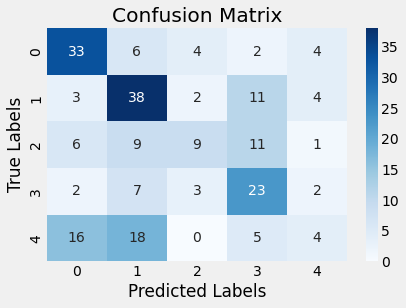

In [ ]:
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
#print(conf_matrix)

# Visualize the confusion matrix as a heatmap
class_names = list(set(y_test))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

63/63 [==============================] - 0s 2ms/step
Confusion Matrix:


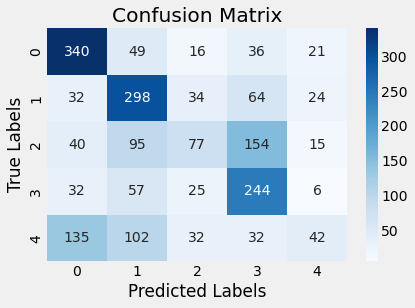

In [ ]:
# Evaluate the model on the train set
y_pred = best_model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_train_onehot, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
#print(conf_matrix)

# Visualize the confusion matrix as a heatmap
class_names = list(set(y_train))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the best deep learning model
best_model.save("deep_learning_model.h5")

In [ ]:
# Function to get the sentence-level embedding by averaging word embeddings
def get_sentence_embedding(tokens):
    embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    #print(embeddings)
    if embeddings:
        return np.mean(embeddings, axis=0)  # this linr to avearge the word vectors of a sentance
    return None

In [ ]:
def predict_sentiment(review_text):
    
    
    # Preprocess the review_text and convert it into a Word2Vec representation
    review_sequence = tokenizer.texts_to_sequences([review_text])
    review_sequence = pad_sequences(review_sequence, maxlen=100)

    # Make prediction using the deep learning model
    prediction = model.predict(review_sequence)
    sentiment_label = 'positive' if prediction[0][0] > 0.5 else 'negative'

    return sentiment_label
